In [4]:
from google.colab import files
uploaded = files.upload()

Saving Dataset of Diabetes .csv to Dataset of Diabetes .csv


# 📦 IMPORT REQUIRED LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📥 Load the dataset

In [5]:

data = pd.read_csv("Dataset of Diabetes .csv")
data['CLASS'] = data['CLASS'].str.strip()


# 🧹 Clean & preprocess

In [6]:

data = data[data['CLASS'].isin(['N', 'Y'])]  # Drop 'P' class if exists
data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})
data = data.drop(['ID', 'No_Pation'], axis=1)  # Drop identifiers

# LABEL ENCODING CLASSES

In [7]:
y = LabelEncoder().fit_transform(data['CLASS'])  # 'N' -> 0, 'Y' -> 1
X = data.drop(['CLASS'], axis=1)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🧪 Check and clean invalid values

In [9]:
print("Any NaNs in scaled input?", np.isnan(X_scaled).any())
print("Any Infs in scaled input?", np.isinf(X_scaled).any())
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

Any NaNs in scaled input? True
Any Infs in scaled input? False


# 🔁 Convert to tensors

In [10]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 🧠 AE Architecture

In [11]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat  # ✅ Correct return


# ⚙️ Training AE

In [12]:
input_dim = X_tensor.shape[1]
ae = Autoencoder(input_dim)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [13]:
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Trained for 300 epochs to get less loss (have runned this code 3 times)

In [56]:
for epoch in range(100):
    total_loss = 0
    for batch_x, _ in dataloader:
        optimizer.zero_grad()
        x_hat = ae(batch_x)
        loss = criterion(x_hat, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 0.0655
Epoch 2, Loss: 0.0648
Epoch 3, Loss: 0.0663
Epoch 4, Loss: 0.0656
Epoch 5, Loss: 0.0657
Epoch 6, Loss: 0.0649
Epoch 7, Loss: 0.0654
Epoch 8, Loss: 0.0657
Epoch 9, Loss: 0.0662
Epoch 10, Loss: 0.0666
Epoch 11, Loss: 0.0689
Epoch 12, Loss: 0.0682
Epoch 13, Loss: 0.0672
Epoch 14, Loss: 0.0651
Epoch 15, Loss: 0.0654
Epoch 16, Loss: 0.0649
Epoch 17, Loss: 0.0663
Epoch 18, Loss: 0.0667
Epoch 19, Loss: 0.0665
Epoch 20, Loss: 0.0669
Epoch 21, Loss: 0.0654
Epoch 22, Loss: 0.0653
Epoch 23, Loss: 0.0655
Epoch 24, Loss: 0.0658
Epoch 25, Loss: 0.0655
Epoch 26, Loss: 0.0662
Epoch 27, Loss: 0.0661
Epoch 28, Loss: 0.0653
Epoch 29, Loss: 0.0655
Epoch 30, Loss: 0.0652
Epoch 31, Loss: 0.0641
Epoch 32, Loss: 0.0654
Epoch 33, Loss: 0.0646
Epoch 34, Loss: 0.0637
Epoch 35, Loss: 0.0641
Epoch 36, Loss: 0.0651
Epoch 37, Loss: 0.0647
Epoch 38, Loss: 0.0653
Epoch 39, Loss: 0.0649
Epoch 40, Loss: 0.0665
Epoch 41, Loss: 0.0667
Epoch 42, Loss: 0.0662
Epoch 43, Loss: 0.0644
Epoch 44, Loss: 0.06

# 🔍 Extract Latent Features

In [57]:
with torch.no_grad():
    latent_features = ae.encoder(X_tensor).numpy()

# Splitting Train and Test data

In [59]:
xTrain, xTest, yTrain, yTest = train_test_split(latent_features, y, test_size=0.2, random_state=42)

# 🧪 RFC Pipeline with GridSearchCV

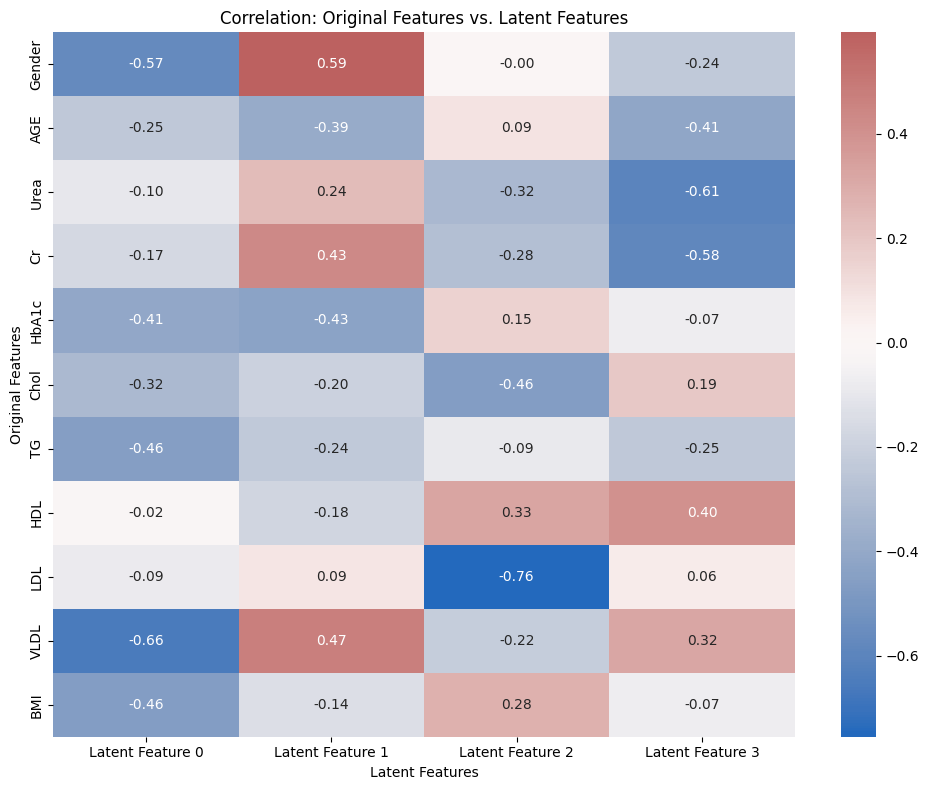

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a DataFrame for the original scaled features
# Make sure 'X_scaled' and 'X.columns' are from your preprocessing steps
df_scaled_original = pd.DataFrame(X_scaled, columns=X.columns)

# 2. Create a DataFrame for the new latent features
# 'latent_features' is the numpy array from your autoencoder
latent_dim = latent_features.shape[1]
latent_col_names = [f'Latent Feature {i}' for i in range(latent_dim)]
df_latent = pd.DataFrame(latent_features, columns=latent_col_names)

# 3. Concatenate them into one big DataFrame
df_combined = pd.concat([df_scaled_original, df_latent], axis=1)

# 4. Calculate the full correlation matrix
corr_matrix = df_combined.corr()

# 5. Isolate only the correlations we care about
# We want to see Original Features (rows) vs. Latent Features (columns)
correlation_of_interest = corr_matrix.loc[X.columns, latent_col_names]

# 6. Plot the heatmap
plt.figure(figsize=(10, 8)) # You can adjust the size
sns.heatmap(
    correlation_of_interest,
    annot=True,       # Show the correlation values
    fmt=".2f",        # Format to 2 decimal places
    cmap="vlag",      # A good diverging colormap (blue-white-red)
    center=0          # Center the colormap at 0, making it easy to see pos/neg
)
plt.title("Correlation: Original Features vs. Latent Features")
plt.ylabel("Original Features")
plt.xlabel("Latent Features")
plt.tight_layout()
plt.savefig("latent_feature_correlation.png") # Save the plot
plt.show()

In [61]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__n_estimators': [100, 200, 300, 400, 500],
    'clf__max_depth': [None, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2,3,4, 5],
    'clf__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',  # better if classes are imbalanced
    n_jobs=-1,
    verbose=2
)

print("\n🔍 Running GridSearchCV on AE latent features...")



🔍 Running GridSearchCV on AE latent features...


In [63]:
# Fit on latent features
grid_search.fit(xTrain, yTrain)

# Best parameters
print("\n🏆 Best Parameters Found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

🏆 Best Parameters Found:
{'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}


In [64]:
best_model = grid_search.best_estimator_
yPred = best_model.predict(xTest)

# ACCURACY and CLASSIFICATION REPORT with GridSearchCV

In [69]:
print("\n✅ Evaluation on AE latent features:")
print("Accuracy:", accuracy_score(yTest, yPred))
print("Classification Report:\n", classification_report(yTest, yPred))


✅ Evaluation on AE latent features:
Accuracy: 0.968421052631579
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.97      1.00      0.98       170

    accuracy                           0.97       190
   macro avg       0.98      0.85      0.90       190
weighted avg       0.97      0.97      0.97       190



# ACCURACY and CLASSIFICATION REPORT only RFC Pipeline

In [70]:
y_pred_1 = pipeline.fit(xTrain, yTrain).predict(xTest)

print("\n✅ Evaluation on AE latent features:")
print("Accuracy:", accuracy_score(yTest, y_pred_1))
print("Classification Report:\n", classification_report(yTest, y_pred_1))


✅ Evaluation on AE latent features:
Accuracy: 0.9578947368421052
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        20
           1       0.96      1.00      0.98       170

    accuracy                           0.96       190
   macro avg       0.98      0.80      0.86       190
weighted avg       0.96      0.96      0.95       190



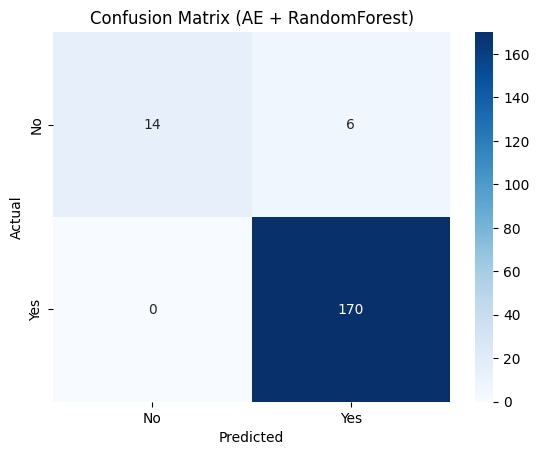

In [71]:
# 📉 Confusion Matrix
conf_matrix = confusion_matrix(yTest, yPred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (AE + RandomForest)')
plt.show()

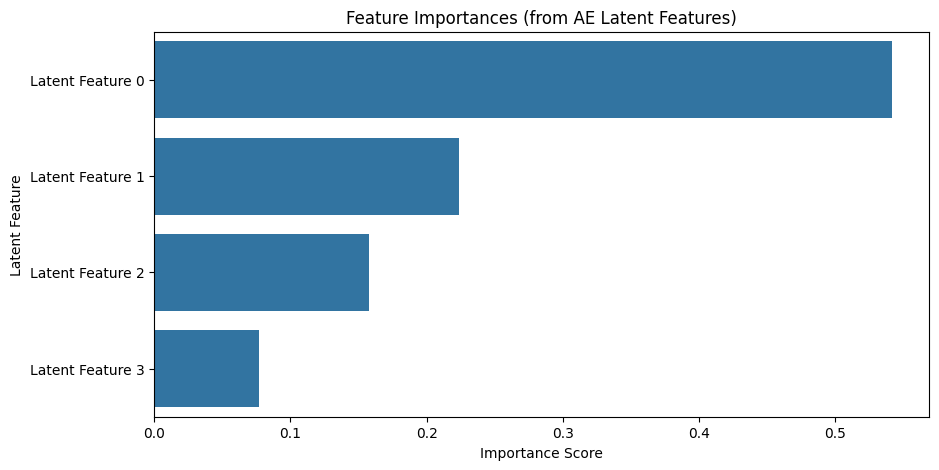

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importances from the best model
# This model was trained on the latent features
importances_1 = best_model.named_steps['clf'].feature_importances_

# Get the number of latent features
num_latent_features = len(importances_1)

# Create the CORRECT labels for the latent features
# (e.g., 'Latent Feature 0', 'Latent Feature 1', ...)
latent_feature_names = [f'Latent Feature {i}' for i in range(num_latent_features)]

# Sort the importances and the new labels together
sorted_idx = np.argsort(importances_1)[::-1]
sorted_importances = importances_1[sorted_idx]
sorted_latent_names = np.array(latent_feature_names)[sorted_idx]

# Plotting the corrected feature importances
plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_importances, y=sorted_latent_names)
plt.title("Feature Importances (from AE Latent Features)")
plt.xlabel("Importance Score")
plt.ylabel("Latent Feature")

# Save the plot as a file (optional, but good for notebooks)
plt.savefig("ae_feature_importances.png")
plt.show()

In [73]:
import joblib

In [74]:
model_name = 'AE_RFC.joblib'
joblib.dump(best_model, model_name)


['AE_RFC.joblib']